In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp -r /content/drive/My\ Drive/eva-4/Phase-2/Session-4/* ./

In [ ]:
! nvidia-smi


Sun Aug 23 08:32:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 604.8MB 29kB/s 
     |████████████████████████████████| 6.5MB 645kB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [ ]:
import torch
from IPython.display import Image, clear_output 

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))


PyTorch 1.5.1+cu92 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


In [ ]:
!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=3cb654f1935fe2e2d21ba665018b05f967a2c2246265a9da6070bc8bec7439b3
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [ ]:
from zipfile import ZipFile

def extract_images(zipfilename, targetfolder):
  
  zipObj = ZipFile(zipfilename, 'r')
  #print("zipObj " +zipObj)
  zipObj.extractall(targetfolder)
  zipObj.close()

time: 4.8 ms


In [ ]:
extract_images('/content/drive/My Drive/eva-4/Phase-2/Session-4/new_data_final_split_lfw.zip','/content')

time: 3.51 s


In [ ]:
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
import torchvision
from models.inception_resnet_v1 import InceptionResnetV1
import cv2
from PIL import Image
import PIL
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, tqdm
import csv
import glob
import dlib
import pandas as pd
import numpy as np
import glob
from pathlib import Path
from torchsummary import summary
import json

time: 3.31 s


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = '/content/content/new_data_final_split'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,  shuffle=True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
class_names

['AJ_Cook',
 'AJ_Lamas',
 'Aaron_Eckhart',
 'Aaron_Guiel',
 'Aaron_Patterson',
 'Aaron_Peirsol',
 'Aaron_Pena',
 'Aaron_Sorkin',
 'Aaron_Tippin',
 'Abba_Eban',
 'Abbas_Kiarostami',
 'Abdel_Aziz_Al-Hakim',
 'Abdel_Madi_Shabneh',
 'Abdel_Nasser_Assidi',
 'Abdoulaye_Wade',
 'Abdul_Majeed_Shobokshi',
 'Abdul_Rahman',
 'Abdulaziz_Kamilov',
 'Abdullah',
 'Abdullah_Ahmad_Badawi',
 'Abdullah_Gul',
 'Abdullah_Nasseef',
 'Abdullah_al-Attiyah',
 'Abdullatif_Sener',
 'Abel_Aguilar',
 'Abel_Pacheco',
 'Abid_Hamid_Mahmud_Al-Tikriti',
 'Abner_Martinez',
 'Abraham_Foxman',
 'Aby_Har-Even',
 'Adam_Ant',
 'Adam_Freier',
 'Adam_Herbert',
 'Adam_Kennedy',
 'Adam_Mair',
 'Adam_Rich',
 'Adam_Sandler',
 'Adam_Scott',
 'Adel_Al-Jubeir',
 'Adelina_Avila',
 'Adisai_Bodharamik',
 'Adolfo_Aguilar_Zinser',
 'Adolfo_Rodriguez_Saa',
 'Adoor_Gopalakarishnan',
 'Adrian_Annus',
 'Adrian_Fernandez',
 'Adrian_McPherson',
 'Adrian_Murrell',
 'Adrian_Nastase',
 'Adriana_Lima',
 'Adriana_Perez_Navarro',
 'Adrianna_Zuzic',
 

time: 361 ms


In [ ]:
with open('lfw_plus_classnames.json', 'w') as json_file:
  json.dump(class_names, json_file)

time: 8.74 ms


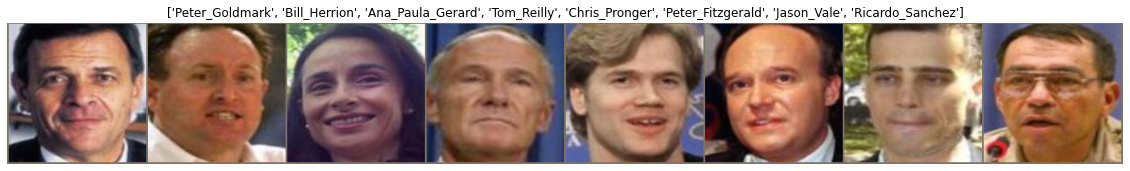

time: 366 ms


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(20, 10))
plt.axis('off')
imshow(out, title=[class_names[x] for x in classes])
plt.show()

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = '/content/content/new_data_final_split'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,  shuffle=True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}

time: 277 ms


In [ ]:
from models.inception_resnet_v1 import InceptionResnetV1
device = torch.device("cuda:0")
print('Running on device: {}'.format(device))
model_ft = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes = len(class_names))

Running on device: cuda:0



time: 4.91 s


In [ ]:
layer_list = list(model_ft.children())[-5:] # all final layers
layer_list

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=5759, bias=True)]

time: 6.15 ms


In [ ]:
for param in model_ft.parameters():
    param.requires_grad = False

time: 3.62 ms


In [ ]:
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(1)
model_ft.dropout = nn.Dropout(p=0.6)
model_ft.last_linear = nn.Linear(1792, 512, bias=False)
model_ft.last_bn = nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True)
model_ft.logits = nn.Linear(512, len(class_names))
model_ft = model_ft.to(device)

time: 4.07 s


In [ ]:
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of *gamma* every *step_size* epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)
onecycle_lr_scheduler = lr_scheduler.OneCycleLR(optimizer_ft, max_lr=0.2, steps_per_epoch=len(dataloaders['train']), epochs=25)

time: 7.21 ms


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    FT_losses = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                
                FT_losses.append(loss.item())
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        epoch_end = time.time()
        epoch_elapsed = epoch_end - epoch_start
        print(f'Completed Epoch {epoch} in {epoch_elapsed // 60:.0f}m {epoch_elapsed % 60:.0f}s\n')
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, FT_losses

time: 38.9 ms


In [ ]:
model_ft, FT_losses = train_model(model_ft, criterion, optimizer_ft, onecycle_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 7.4297 Acc: 0.1507
val Loss: 6.7607 Acc: 0.1589
Completed Epoch 0 in 0m 41s

Epoch 1/24
----------
train Loss: 5.4265 Acc: 0.3214
val Loss: 5.0256 Acc: 0.2570
Completed Epoch 1 in 0m 41s

Epoch 2/24
----------
train Loss: 3.8139 Acc: 0.4431
val Loss: 2.6131 Acc: 0.5765
Completed Epoch 2 in 0m 41s

Epoch 3/24
----------
train Loss: 1.9121 Acc: 0.6596
val Loss: 0.4901 Acc: 0.9637
Completed Epoch 3 in 0m 40s

Epoch 4/24
----------
train Loss: 0.2584 Acc: 0.9872
val Loss: 0.1953 Acc: 0.9789
Completed Epoch 4 in 0m 40s

Epoch 5/24
----------
train Loss: 0.0598 Acc: 0.9948
val Loss: 0.1582 Acc: 0.9799
Completed Epoch 5 in 0m 41s

Epoch 6/24
----------
train Loss: 0.0336 Acc: 0.9975
val Loss: 0.1414 Acc: 0.9820
Completed Epoch 6 in 0m 40s

Epoch 7/24
----------
train Loss: 0.0269 Acc: 0.9981
val Loss: 0.1266 Acc: 0.9827
Completed Epoch 7 in 0m 40s

Epoch 8/24
----------
train Loss: 0.0184 Acc: 0.9986
val Loss: 0.1231 Acc: 0.9838
Completed Epoch 8 in 0m 40s

E

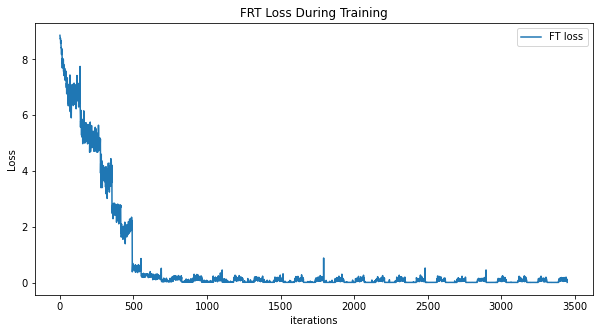

time: 156 ms


In [ ]:
plt.figure(figsize=(10,5))
plt.title("FRT Loss During Training")
plt.plot(FT_losses, label="FT loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
torch.save(model_ft, '/content/drive/My Drive/eva-4/Phase-2/Session-4/models/lfw_plus_model.pt')


time: 494 ms


In [ ]:
traced_model = torch.jit.trace(model_ft.to('cpu'), torch.randn(1, 3, 160, 160))


time: 2.31 s


In [ ]:
traced_model.save('/content/drive/My Drive/eva-4/Phase-2/Session-4/models/lfw_plus_model_traced.pt')


time: 1.36 s
